In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import sklearn.linear_model
import tqdm.notebook as tqdm

In [2]:
direct_gwas_df = (
    pl.scan_csv("data/gwas/direct/result*zst", include_file_paths="path", separator="\t")
    .select(
        "ID",
        pl.col("path").str.strip_prefix("data/gwas/direct/result.").str.strip_suffix(".glm.linear.zst").alias("projection"),
        pl.col("BETA", "SE").name.to_lowercase(),
    )
    .collect()
)
print(direct_gwas_df.shape)
direct_gwas_df.head(2)

(9590000, 4)


ID,projection,beta,se
str,str,f64,f64
"""1:1077064""","""and_q_102_0_q_1737_0""",0.000575,0.0056952
"""1:1108637""","""and_q_102_0_q_1737_0""",-0.005603,0.00868


In [3]:
feature_gwas_df = (
    pl.scan_csv("data/gwas/feature/result*zst", include_file_paths="path", separator="\t")
    .select(
        "ID",
        pl.col("path").str.strip_prefix("data/gwas/feature/result.").str.strip_suffix(".glm.linear.zst"),
        "BETA",
        "SE",
        pl.col("OBS_CT").alias("N")
    )
    .collect()
)

feature_beta_df = (
    feature_gwas_df
    .pivot(index="ID", on="path", values="BETA")
    .to_pandas()
    .set_index("ID")
)
feature_se_df = (
    feature_gwas_df
    .pivot(index="ID", on="path", values="SE")
    .to_pandas()
    .set_index("ID")
)
feature_N_df = (
    feature_gwas_df
    .pivot(index="ID", on="path", values="N")
    .to_pandas()
    .set_index("ID")
)

In [4]:
cov_df = (
    pl.read_csv("data/pheno/original.tsv", separator="\t")
    .drop(["FID", "IID"])
    .to_pandas()
    .cov()
)

In [ ]:
comparison_df = pd.DataFrame()

for k in tqdm.tqdm([0, 5, 10, 15, 20]):
    if k == 0:
        pheno_path = pathlib.Path("data/pheno").joinpath("original.tsv")
        rand_path = pathlib.Path("data/pheno").joinpath("rand_original.tsv")
        pheno_df = pl.read_csv(pheno_path, separator="\t").drop(["FID", "IID"]).with_columns(const=1.0)
        rand_pheno_df = pl.read_csv(rand_path, separator="\t")
    else:
        pheno_path = pathlib.Path("data/pheno").joinpath(f"anon_{k:03}.tsv")
        rand_path = pathlib.Path("data/pheno").joinpath(f"rand_anon_{k:03}.tsv")
        pheno_df = pl.read_csv(pheno_path, separator="\t").drop("n_occurrences").with_columns(const=1.0)
        rand_pheno_df = pl.read_csv(rand_path, separator="\t")

    # Regress the random phenotypes against the features
    # beta, _, _, _ = np.linalg.lstsq(pheno_df.to_numpy(), rand_pheno_df.to_numpy())
    model = sklearn.linear_model.Ridge(fit_intercept=False).fit(pheno_df.to_numpy(), rand_pheno_df.to_numpy())
    beta = model.coef_.T
    beta_df = (
        pd.DataFrame(beta, index=pheno_df.columns, columns=rand_pheno_df.columns)
        .rename_axis(index="feature")
    )
    (
        beta_df
        .reset_index()
        .pipe(pl.DataFrame)
        .write_csv(f"data/indirect-betas/beta_{k:03}.tsv", separator="\t")
    )

    # Perform indirect GWAS
    B = beta_df.loc[lambda df: df.index != "const"].loc[feature_beta_df.columns]
    indirect_beta_df = feature_beta_df @ B
    projection_var_s = pd.Series(np.diag(B.T @ cov_df.loc[feature_beta_df.columns, feature_beta_df.columns] @ B), index=B.columns)
    feature_var_s = pd.Series(np.diag(cov_df), index=cov_df.columns)
    var_g_i_df = feature_var_s / (feature_se_df.pow(2) * (feature_N_df - 1) + feature_beta_df.pow(2))
    var_g_s = var_g_i_df.mean(axis=1)
    indirect_N_s = feature_N_df.min(axis=1)
    variance_ratio_df = (
        pd.DataFrame(np.ones_like(indirect_beta_df.values), index=indirect_beta_df.index, columns=indirect_beta_df.columns)
        .mul(projection_var_s, axis="columns")
        .div(var_g_s, axis="index")
    )
    indirect_se_df = variance_ratio_df.sub(indirect_beta_df.pow(2)).div((indirect_N_s - 1), axis="index").pipe(np.sqrt)

    # Reformat data for easier analysis
    indirect_gwas_df = (
        pd.concat([
            indirect_beta_df
                .melt(ignore_index=False, var_name="projection", value_name="beta")
                .reset_index()
                .set_index(["ID", "projection"]),
            indirect_se_df
                .melt(ignore_index=False, var_name="projection", value_name="se")
                .reset_index()
                .set_index(["ID", "projection"]),
        ], axis=1)
        .reset_index()
        .pipe(pl.DataFrame)
    )
    this_comparison_df = (
        direct_gwas_df
        .unpivot(index=["ID", "projection"], variable_name="sumstat")
        .join(
            indirect_gwas_df.unpivot(index=["ID", "projection"], variable_name="sumstat"),
            on=["ID", "projection", "sumstat"], suffix="_indirect"
        )
        .rename({"value": "direct", "value_indirect": "indirect"})
        .with_columns(pl.lit(k).alias("k"))
    )
    comparison_df = pd.concat([comparison_df, this_comparison_df.to_pandas()])

comparison_df = pl.DataFrame(comparison_df)

comparison_df.write_parquet("data/fits/gwas.parquet")

comparison_df.head(2)

In [3]:
comparison_df = pl.read_parquet("data/fits/gwas.parquet")

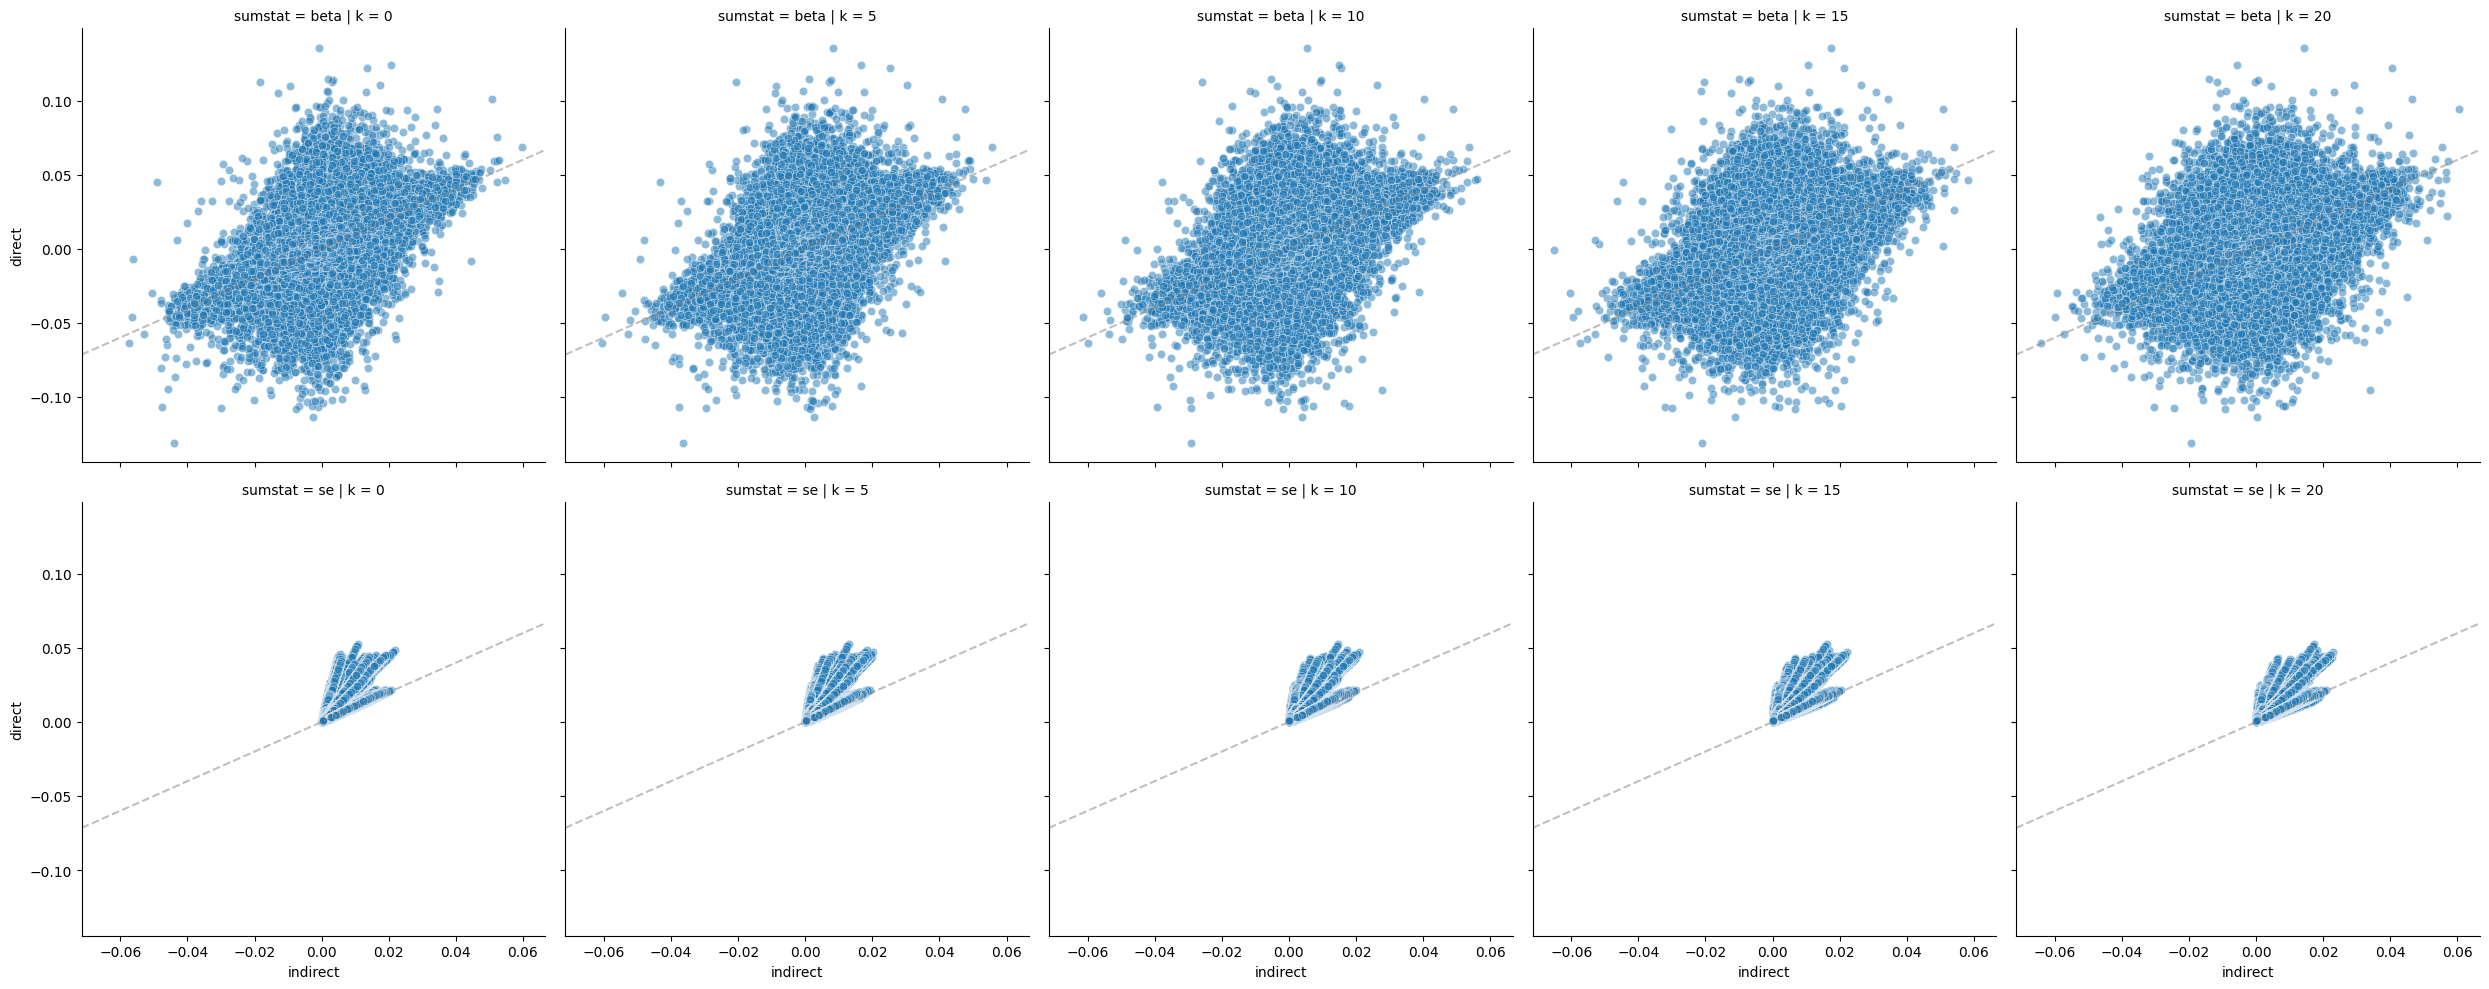

In [4]:
(
    comparison_df
    .pipe(sns.relplot, x="indirect", y="direct", col="k", row="sumstat", alpha=0.5)
    .map(lambda *a, **k: plt.axline((0., 0.), slope=1, linestyle="dashed", color="gray", alpha = 0.5))
)

In [5]:
summary_df = (
    comparison_df
    .unpivot(index=["ID", "projection", "sumstat", "k"], on=["direct", "indirect"])
    .pivot(on="sumstat", values="value")
    .select("ID", "projection", "k", "variable", pl.col("beta").truediv(pl.col("se")).pow(2).alias("chisq"))
    .pivot(on="variable", values="chisq")
    .group_by("projection", "k")
    .agg(
        r2=pl.lit(1) - (
            pl.col("direct").sub(pl.col("indirect")).pow(2).sum() 
            / pl.col("direct").sub(pl.col("direct").mean()).pow(2).sum()
        )
    )
)

summary_df.write_parquet("data/fits/gwas_summary.parquet")

summary_df.head(2)

projection,k,r2
str,i32,f64
"""or_q_5108_5_q_4279_0""",15,0.3364
"""and_q_4230_14_q_4125_0""",5,0.363687
